# Finite Element Analysis of Heat Conductio on a Square

## Preamble

In [1]:
from dolfinx import default_scalar_type
from dolfinx.fem import (Constant, Function, functionspace, assemble_matrix,
                         assemble_scalar, dirichletbc, form, locate_dofs_geometrical)
from dolfinx.fem.petsc import LinearProblem
from dolfinx import mesh
from dolfinx.plot import vtk_mesh

from mpi4py import MPI
from ufl import SpatialCoordinate, TestFunction, TrialFunction, dot, ds, dx, grad, Mesh, triangle


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pyvista, pygmsh, gmsh, meshio

## Utility functions

In [2]:
def plot_errors(h, e, l, x_label='$h$', y_label='$\epsilon_{L_2}$', title=''):
    """
    Plots the error vs mesh size on a log-log plot.

    Args:
    h : array-like
        Vector of mesh sizes.
    e : 2D array-like
        Matrix where each row corresponds to the errors for a specific label.
    l : array-like
        List of labels for each row in the error matrix.
    """
    
    # Create a log-log plot
    plt.figure(figsize=(8, 6))
    
    # Plot each row of errors with the corresponding label
    for i, label in enumerate(l):
        plt.loglog(h[i], e[i], label=label, marker='o')
    
    # Add labels and title
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title(title, fontsize=14)
    
    # Add a legend
    plt.legend()
    
    # Enable grid
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    
    # Show the plot
    plt.show()

In [3]:
def plot_sparseness(a):
    A = assemble_matrix(form(a))
    
    A_scipy = A.to_scipy()

    no_non_zeros = A_scipy.nnz
    no_dofs = A_scipy.shape[0]

    print(f"Number of degrees of freedom: {no_dofs}")
    print(f"Number of non-zeros: {no_non_zeros}")
    print(f"Covering fraction: {100*no_non_zeros/no_dofs/no_dofs:.2f}%")
    
    # Plot the sparsity pattern
    plt.figure(figsize=(8, 8))
    plt.spy(A_scipy, markersize=1)
    plt.show()

In [4]:
def generate_error_table_general(ms, e, l):
    """
    Generates a pandas DataFrame containing mesh sizes, errors, and convergence rates.
    This version handles any number of error rows.
    
    Args:
    - ms: List of mesh sizes.
    - e: List of lists containing error data for different methods.
    - l: List of column labels (first label is for mesh sizes).
    
    Returns:
    - DataFrame containing errors and convergence rates.
    """
    
    # Create a pandas DataFrame with mesh sizes
    data = pd.DataFrame({l[0]: ms})
    
    # Add the error columns to the DataFrame
    for i in range(1, len(l)):
        data[l[i]] = e[i-1]
    
    # Function to calculate convergence rates
    def compute_convergence_rates(errors, mesh_sizes):
        rates = []
        for i in range(1, len(errors)):
            rate = np.log(errors[i] / errors[i-1]) / np.log(mesh_sizes[i] / mesh_sizes[i-1])
            rates.append(rate)
        rates.insert(0, np.nan)  # Insert NaN for the first entry where rate can't be computed
        return rates

    # Add the convergence rate columns
    for i in range(1, len(l)):
        rate_col = f'rate_{l[i]}'
        data[rate_col] = compute_convergence_rates(e[i-1], ms)

    return data

## Problem parameters

In [5]:
x_min, x_max = 0.2, 1.2  # Lower-left corner
y_min, y_max = 0.0, 1.0 # Upper-right corner

h = 1/8  # Mesh size
element_order = 1

## Mesh Generation

In [6]:
with pygmsh.geo.Geometry() as geom:
    # Create the circle
    rectangle = geom.add_rectangle(x_min, x_max, y_min, y_max, 0, mesh_size=h)
    
    # Generate the mesh
    mesh_io = geom.generate_mesh()
    
    # Extract points and cells (triangles) from the meshio.Mesh object
    points = mesh_io.points[:, :2]  # Only take the 2D coordinates
    cells = np.vstack([cell.data for cell in mesh_io.cells if "triangle" in cell.type])

    # Create the FEniCSx mesh (points as geometry, cells as topology)
    topology = cells.astype(np.int32)
    geometry = points
    
    ufl_domain = Mesh(triangle)
    domain = mesh.create_mesh(MPI.COMM_WORLD, topology, geometry, ufl_domain)

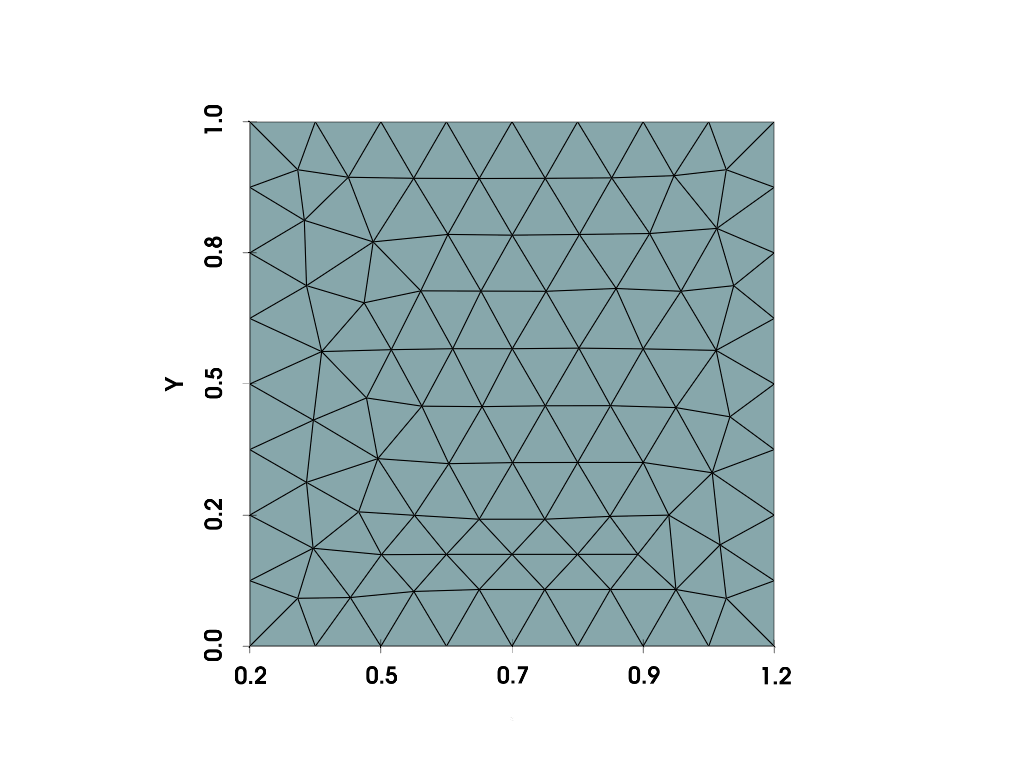

In [7]:
pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(domain, 2)

grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.show_grid(
    xtitle='X',        # Custom label for X axis
    ytitle='Y',        # Custom label for Y axis
    grid=None               # Suppress grid lines
)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()

## Weak form

In [8]:
V = functionspace(domain, ("Lagrange", element_order))
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v)) * dx

In [9]:
def u_exact(x):
    return x[0] / (x[0]**2 + x[1]**2)

def boundary_x_min(x):
    return np.isclose(x[0], x_min)

def boundary_x_max(x):
    return np.isclose(x[0], x_max)

def boundary_y_min(x):
    return np.isclose(x[1], y_min)

def boundary_y_max(x):
    return np.isclose(x[1], y_max)

boundary_dofs_x_min = locate_dofs_geometrical(V, boundary_x_min)
boundary_dofs_x_max = locate_dofs_geometrical(V, boundary_x_max)
boundary_dofs_y_min = locate_dofs_geometrical(V, boundary_y_min)
boundary_dofs_y_max = locate_dofs_geometrical(V, boundary_y_max)

u_bc = Function(V)
u_bc.interpolate(u_exact)

dofs_D = np.hstack([boundary_dofs_x_min, boundary_dofs_x_max, boundary_dofs_y_min, boundary_dofs_y_max])
bc = dirichletbc(u_bc, dofs_D)

In [10]:
f = Constant(domain, default_scalar_type(0))
L = f * v * dx

## Assembling and solution

Number of degrees of freedom: 98
Number of non-zeros: 616
Covering fraction: 6.41%


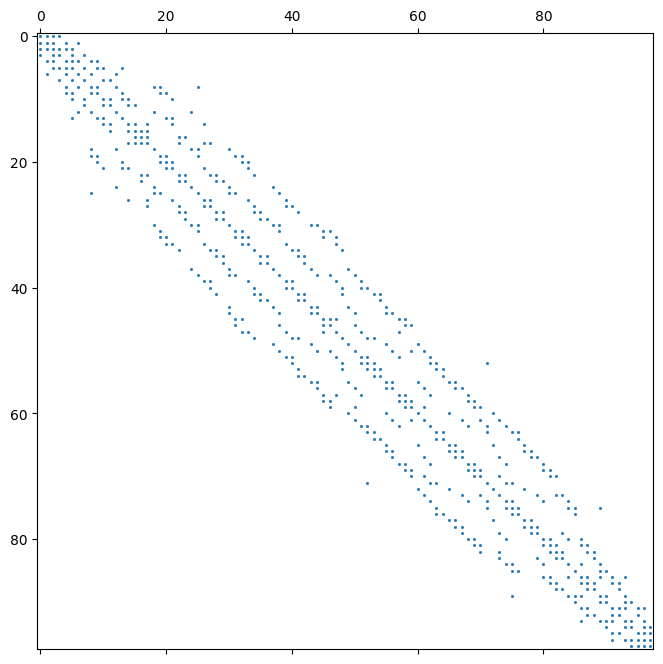

In [11]:
plot_sparseness(a)

In [12]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "cholesky"})
uh = problem.solve()

## Results

In [13]:
V2 = functionspace(domain, ("Lagrange", 8))
uex = Function(V2)
uex.interpolate(u_exact)
error_L2 = assemble_scalar(form((uh - uex)**2 * dx))
error_L2 = np.sqrt(MPI.COMM_WORLD.allreduce(error_L2, op=MPI.SUM))

u_vertex_values = uh.x.array
uex_1 = Function(V)
uex_1.interpolate(uex)
u_ex_vertex_values = uex_1.x.array
n_dof = u_vertex_values.shape[0]

error_max = np.max(np.abs(u_vertex_values - u_ex_vertex_values))
error_max = MPI.COMM_WORLD.allreduce(error_max, op=MPI.MAX)
print(f"Number of degrees of freedom: {n_dof}")
print(f"Error_L2 : {error_L2:.6e}")
print(f"Error_max : {error_max:.6e}")

Number of degrees of freedom: 98
Error_L2 : 1.474202e-02
Error_max : 1.093852e-02


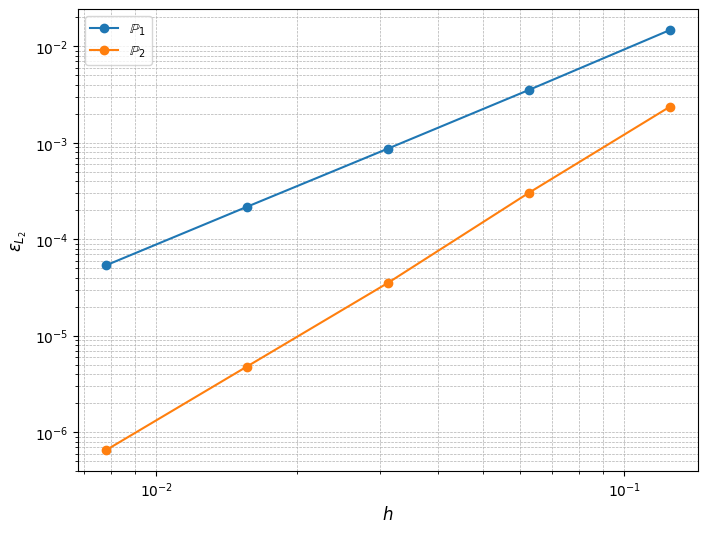

In [14]:
ms = [[1/8, 1/16, 1/32, 1/64, 1/128]]*2
e = [
    [1.474202e-02, 3.530963e-03, 8.707821e-04, 2.172910e-04, 5.374903e-05],
    [2.360597e-03, 3.029080e-04, 3.529355e-05, 4.796658e-06, 6.521020e-07]]
l = ['$\mathbb{P}_1$', '$\mathbb{P}_2$']

plot_errors(ms, e, l)

In [15]:
generate_error_table_general(ms[1], e, ['$h$'] + l)

,$h$,$\mathbb{P}_1$,$\mathbb{P}_2$,rate_$\mathbb{P}_1$,rate_$\mathbb{P}_2$
0,0.125000,0.014742,2.360597e-03,NaN,NaN
1,0.062500,0.003531,3.029080e-04,2.061801,2.962200
2,0.031250,0.000871,3.529355e-05,2.019678,3.101403
3,0.015625,0.000217,4.796658e-06,2.002683,2.879303
4,0.007812,0.000054,6.521020e-07,2.015318,2.878860


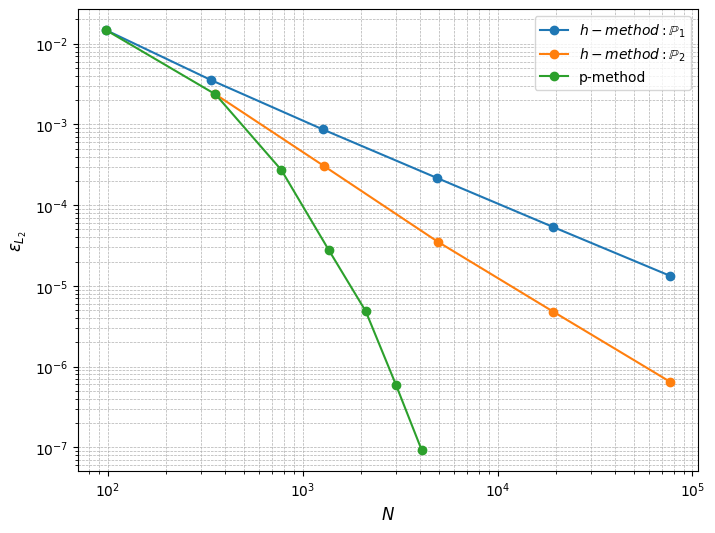

In [16]:
N = [
    [98, 340, 1265, 4887, 19241,76377],
    [357, 1293, 4929, 19289, 76449],
    [98, 357, 778, 1361, 2106, 3013, 4082]]
e = [
    [1.474202e-02, 3.530963e-03, 8.707821e-04, 2.172910e-04, 5.374903e-05,1.338665e-05],
    [2.360597e-03, 3.029080e-04, 3.529355e-05, 4.796658e-06, 6.521020e-07],
    [1.474202e-02, 2.360597e-03, 2.720381e-04, 2.783486e-05, 4.861155e-06,5.927400e-07,9.225960e-08]]
l = ['$h-method: \mathbb{P}_1$', '$h-method: \mathbb{P}_2$', 'p-method']

plot_errors(N, e, l, '$N$')